# Predict Geographic Context from Landscape Photos

Manually download data from Kaggle: https://www.kaggle.com/competitions/predict-geographic-context-from-landscape-photos/overview

Make sure you have the following folders at root level:
- `test_images/`
- `train_images/`

Some training images were missing from the original 14Gb archive (as per Kaggle description). So make sure to also download the missing ones, then combine them with the original training images:

```
rsync -a extra_images/ train_images/
```

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# 0. Let's load metadata and look at some stats

In [5]:
num_labels = 49 # There are 49 tags, not 48 (ignore Kaggle readme)

In [35]:
# Combine original + missing training data (img IDs + labels) into a single CSV
train = pd.concat([
    pd.read_csv('kaggle_data/train.csv'),
    pd.read_csv('kaggle_data/train-extra.csv')
]).drop(columns=['tags'])

test = pd.read_csv('kaggle_data/test.csv')

metadata_cols = ['gridimage_id', 'title', 'grid_reference']
metadata = pd.concat([
    pd.read_csv('kaggle_data/metadata.csv', on_bad_lines='skip', usecols=metadata_cols),
    pd.read_csv('kaggle_data/metadata-extra.csv', on_bad_lines='skip', encoding='latin1', usecols=metadata_cols)
])

In [67]:
metadata

,gridimage_id,title,grid_reference
0,6602,Heathrow Airport,TQ0775
1,7058,The west summit of Beinn na h-Eaglaise,NG9051
2,7567,Summit of Meall an Lundain,NO0694
3,8281,Summit of Beinn na Gucaig,NN0665
4,9017,Duns Castle and Hen Poo,NT7854
...,...,...,...
47408,7562941,Exton : Xmoor-Rox Festival,SS9234
47409,7562943,Exton : Xmoor-Rox Festival,SS9234
47410,7562944,Exton : Xmoor-Rox Festival,SS9234
47411,7563159,Kineil terminal,NS9680


In [51]:
train_combined = (
    train.merge(
        metadata, on='gridimage_id', how='inner'
    ).assign(
        gridimage_id=lambda df_: df_.gridimage_id.astype(int)
    )
    .set_index('gridimage_id')
)

In [52]:
tags = train.columns[1:num_labels+1]
assert len(tags) == num_labels and all([ tag.startswith('tag') for tag in tags ])
train_image_ids = train_combined.index
ys = train_combined.loc[:, tags]
train_titles = train_combined.title.fillna('')

## How many tags per image?

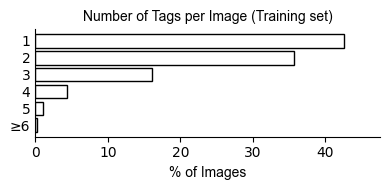

In [134]:
# How many tags per image do we have?
tag_counts = pd.Series(ys.sum(axis=1)).value_counts()

# Group into bins
grouped = {
    '1': tag_counts.get(1, 0),
    '2': tag_counts.get(2, 0),
    '3': tag_counts.get(3, 0),
    '4': tag_counts.get(4, 0),
    '5': tag_counts.get(5, 0),
    '≥6': tag_counts[tag_counts.index >= 6].sum()
}

# Convert to percentages
total = ys.shape[0]
grouped_pct = {k: round((v / total) * 100, 2) for k, v in grouped.items()}

fig, ax = plt.subplots(figsize=(4, 2))

# Sort keys in reverse order
keys = list(grouped_pct.keys())[::-1]
values = [grouped_pct[k] for k in keys]

# Plot
plt.barh(keys, values, color='white', edgecolor='black')
plt.title('Number of Tags per Image (Training set)', fontsize=10, fontname='Arial')
plt.xlabel('% of Images', fontname='Arial')

ax.tick_params(axis='y', length=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(0, max(grouped_pct.values()) + 5)
plt.tight_layout()
plt.savefig("figures/tag_distribution.pdf", format="pdf")

plt.show()

In [11]:
print('Images with titles:', metadata.title.str.strip().str.len().gt(0).mean() * 100, '%')
print('Av title length:', metadata.title.str.strip().str.len().mean())
print('Longest title:', metadata.title.str.strip().str.len().max())

Images with titles: 99.98599764861414 %
Av title length: 28.20612833753673
Longest title: 128.0


In [12]:
#metadata[metadata.title.str.len() == 128].title.to_list()
#metadata[metadata.title.str.len() == 10].title.to_list()

## Img title length

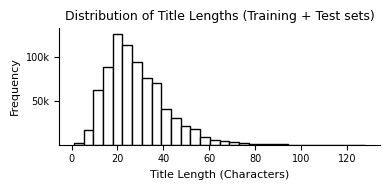

In [13]:
# Compute title lengths
title_lengths = metadata.title.str.len()

# Plot
fig, ax = plt.subplots(figsize=(4, 2))
ax.hist(title_lengths, bins=30, color='white', edgecolor='black')

# Style
ax.set_xlabel('Title Length (Characters)', fontsize=8, color='black')
ax.set_ylabel('Frequency', fontsize=8, color='black')
ax.set_title('Distribution of Title Lengths (Training + Test sets)', fontsize=9, color='black')
ax.tick_params(axis='both', labelsize=7, colors='black')

ax.set_yticks([50000, 100_000])
ax.set_yticklabels(['50k', '100k'])

plt.tight_layout()
plt.savefig("figures/title_length_distribution.pdf", format="pdf")
plt.show()

### Let's build a word cloud

- Courtesy of https://www.geeksforgeeks.org/generating-word-cloud-python/

In [2]:
from wordcloud import WordCloud, STOPWORDS
import re

In [74]:
text = ' '.join(titles.str.lower().astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

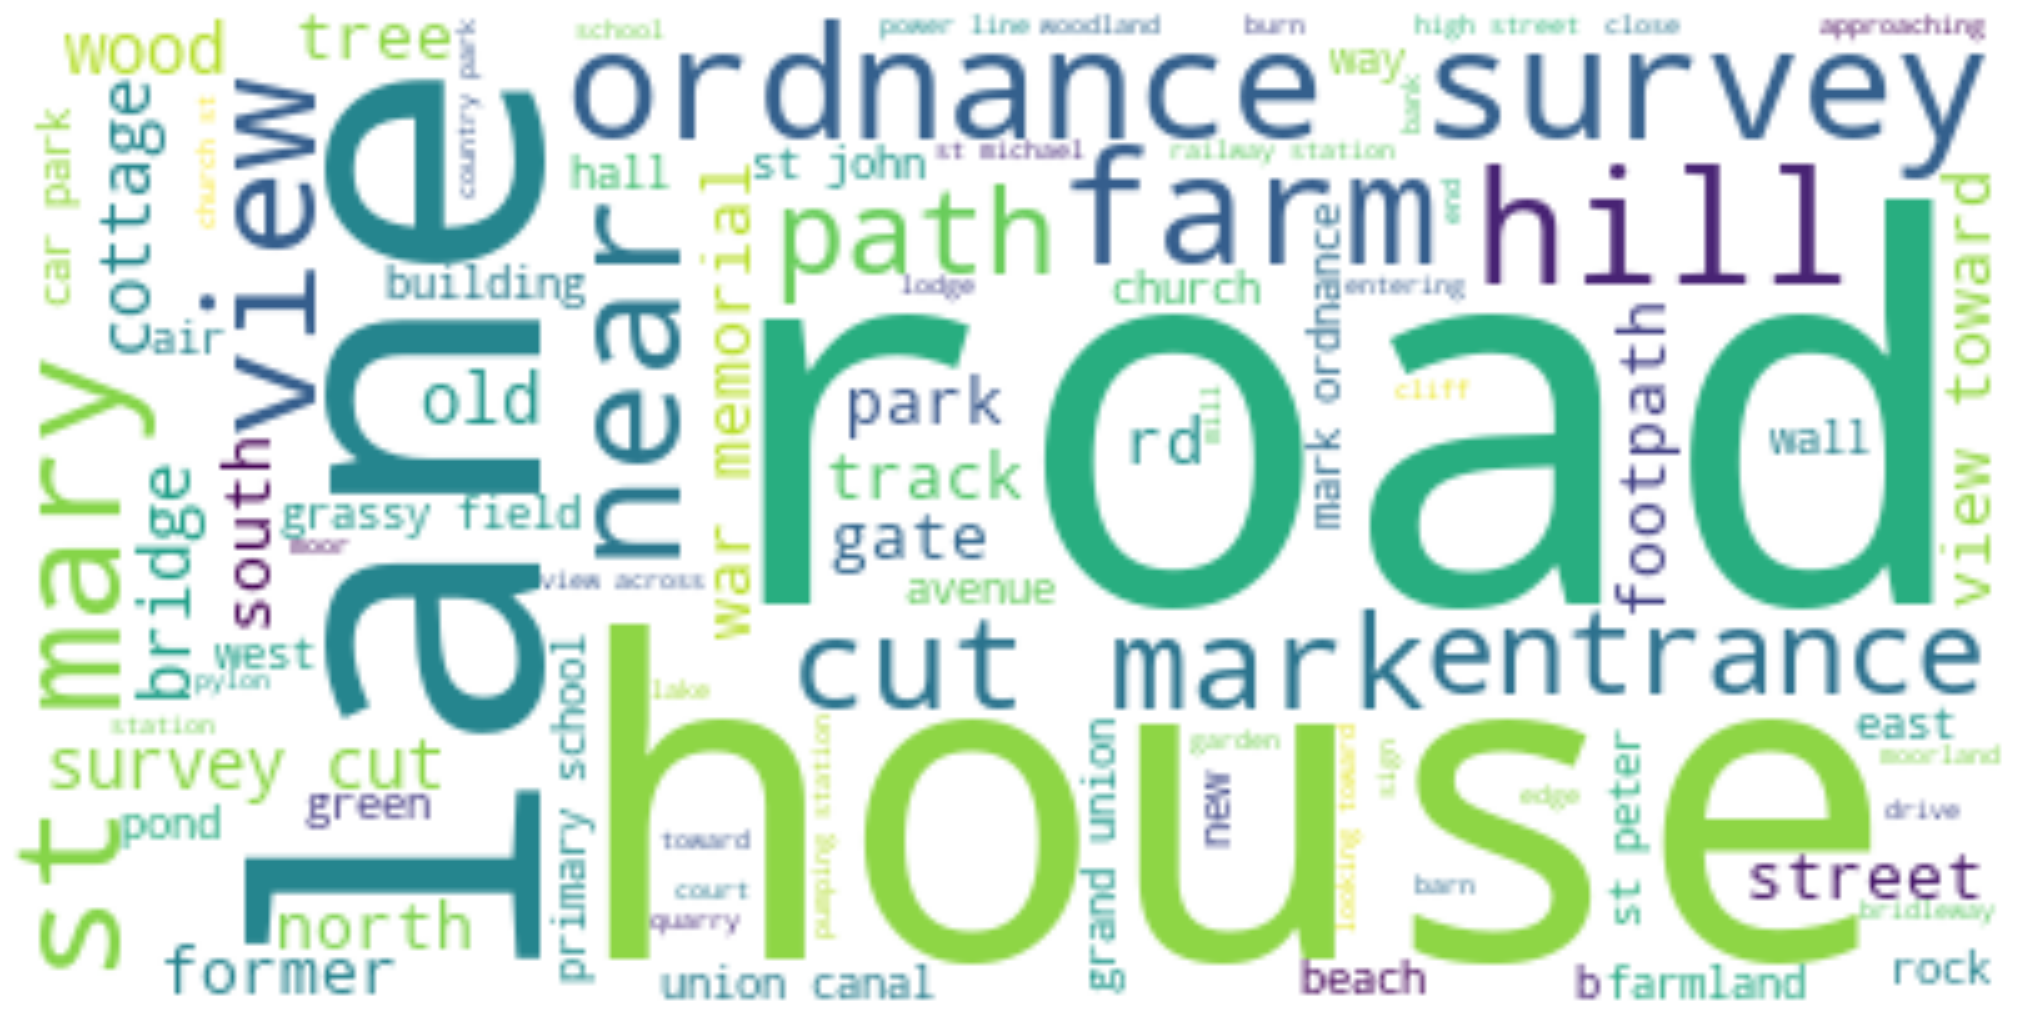

In [90]:
wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("figures/title_wordcloud.pdf", format="pdf")

plt.show()

## Get one image per tag and make a 7x7 grid

In [16]:
def get_img(i):
    path = Path('train_images') / f'{i//10000:05d}' / f'{i}.jpg'
    if path.exists():
        return Image.open(path)

grid_imgs = []
for tag in tags:

    while True: # Just in case some images don't exist
        sample_image = ys[(ys[tag] == 1) & (ys.sum(axis=1) == 1)].sample(1).iloc[0].name
        img_ = get_img(sample_image)
        if img_:
            grid_imgs.append(img_)
            break

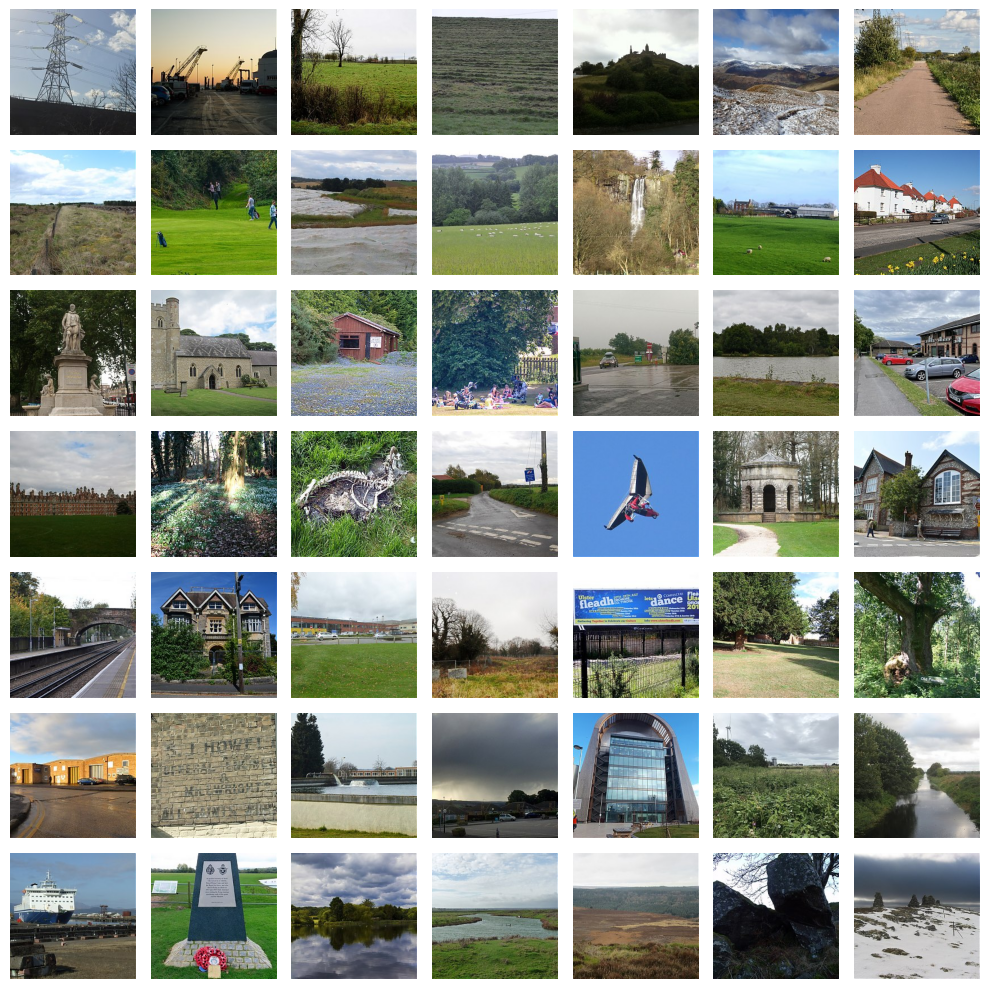

In [17]:
# Plot 7x7 grid
fig, axs = plt.subplots(7, 7, figsize=(10, 10))
for ax, img in zip(axs.flatten(), grid_imgs):
    ax.imshow(img)
    #ax.set_title(tag, fontsize=6)
    ax.axis('off')

plt.tight_layout()
plt.savefig("figures/7x7_collage.pdf", format="pdf")
plt.show()

## Let's now look at the geographical coverage

Download OS BNG grids - https://github.com/OrdnanceSurvey/OS-British-National-Grids and extract from the .7z archive

In [ ]:
# On a Mac, run below to download and unzip:
!wget https://github.com/OrdnanceSurvey/OS-British-National-Grids/raw/refs/heads/main/os_bng_grids.7z -P ./misc/
!brew install p7zip
!7z x ./misc/os_bng_grids.7z -o./misc/

In [94]:
grid = gpd.read_file(
    'misc/os_bng_grids.gpkg',
    layer='1km_grid'
).rename(
    columns={'tile_name': 'grid_reference'}
).to_crs(27700)

(-27600.0, 689600.0, -55800.0, 1281800.0)

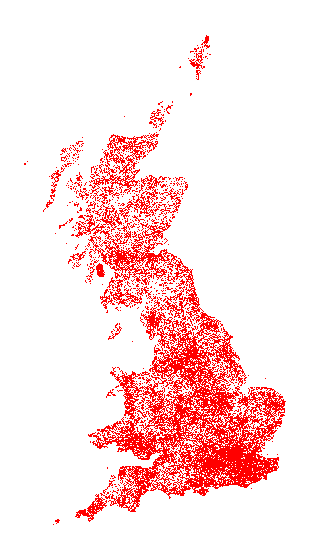

In [107]:
(grid.merge(
     metadata.merge(train, on='gridimage_id', how='inner')[['grid_reference']],
     on='grid_reference',
     how='inner'
 )
 .drop_duplicates('grid_reference')
 .plot(color='red', figsize=(7,7))
 .axis('off')
)

(-25450.0, 688450.0, -53700.0, 1281700.0)

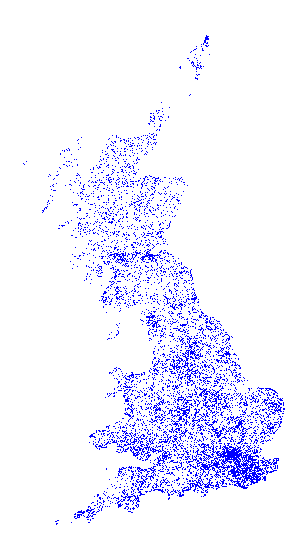

In [36]:
(grid.merge(
     metadata.merge(test, on='gridimage_id', how='inner')[['grid_reference']],
     on='grid_reference',
     how='inner'
 )
 .drop_duplicates('grid_reference')
 .plot(color='blue', figsize=(7,7))
 .axis('off')
)

# 1a. Pre-compute embeddings on all TRIANING images once 🏹

In [3]:
import clip
import torch
from tqdm.notebook import tqdm  # notebook-aware bar

In [41]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [39]:
device = 'cpu'

In [40]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
%%time

batch_size = 10_000
batch_idx = 0

exist_ids = []
img_embeds = []
txt_embeds = []

for img_id in tqdm(train_image_ids[batch_size*batch_idx:]):
    
    path = Path('train_images') / f'{img_id//10000:05d}' / f'{img_id}.jpg'
    
    if path.exists():

        # Image encoder
        img = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feat_img = model.encode_image(img)
        feat_img = feat_img.squeeze(0).cpu().detach()

        # Text encoder
        txt_tokens = clip.tokenize([train_titles.loc[img_id]]).to(device)
        with torch.no_grad():
            feat_txt = model.encode_text(txt_tokens)
        feat_txt = feat_txt.squeeze(0).cpu().detach()
        
        exist_ids.append(img_id)
        img_embeds.append(feat_img)
        txt_embeds.append(feat_txt)

        if len(exist_ids) >= batch_size:
            # Write batch to file
            with open(f'embeds/clip-train-embeds-{batch_idx}.pkl', 'wb') as f:
                pickle.dump(
                    [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
                    f
                )
            exist_ids.clear(); img_embeds.clear(); txt_embeds.clear()
            batch_idx += 1

# Write remaining
with open(f'embeds/clip-train-embeds-{batch_idx}.pkl', 'wb') as f:
    pickle.dump(
        [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
        f
    )

# 1b. Pre-compute embeddings on all TEST images, also once 🏹

In [56]:
test_combined = (
    test.merge(metadata, on='gridimage_id', how='inner')
    .assign(
        gridimage_id=lambda df_: df_.gridimage_id.astype(int)
    )
    .set_index('gridimage_id')
)

test_titles = test_combined.title.fillna('')
test_image_ids = test_combined.index

In [57]:
assert len(test_titles) == len(test_image_ids)

In [ ]:
%%time

batch_size = 10_000
batch_idx = 0

exist_ids = []
img_embeds = []
txt_embeds = []

for img_id in tqdm(test_image_ids[batch_size*batch_idx:]):

    exist_ids.append(img_id)
    
    try: # Image encoder - some imgs don't exist so use try/catch
        path = Path('test_images') / f'{img_id//10000:05d}' / f'{img_id}.jpg'
        img = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feat_img = model.encode_image(img)
        feat_img = feat_img.squeeze(0).cpu().detach()
        img_embeds.append(feat_img)
    except:
        print(f'Path {path} does not exist, skipping.')
        img_embeds.append(None)

    # Text encoder
    txt_tokens = clip.tokenize([test_titles.loc[img_id]]).to(device)
    with torch.no_grad():
        feat_txt = model.encode_text(txt_tokens)
    feat_txt = feat_txt.squeeze(0).cpu().detach()
    txt_embeds.append(feat_txt)

    assert len(exist_ids) == len(img_embeds) == len(txt_embeds)
    
    if len(exist_ids) >= batch_size:
        # Write batch to file
        with open(f'embeds/clip-test-embeds-{batch_idx}.pkl', 'wb') as f:
            pickle.dump(
                [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
                f
            )
        exist_ids.clear(); img_embeds.clear(); txt_embeds.clear()
        batch_idx += 1

# Write remaining
with open(f'embeds/clip-test-embeds-{batch_idx}.pkl', 'wb') as f:
    pickle.dump(
        [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
        f
    )

# 2. Split training images into train/val sets

Let's use the same split for all experiments

In [4]:
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, random_split

In [62]:
train_tuples = []

for i in range(65):
    with open(f'embeds/clip-train-embeds-{i}.pkl', 'rb') as f:
        train_tuples.extend(pickle.load(f))

labels = np.array([ ys.loc[id].values for id, _, _ in train_tuples ])
img_ids = np.array([ id for id, _, _ in train_tuples ])

In [63]:
# Let's hide all examples with 6+ labels from training 
train_mask = labels.sum(axis=1) <= 5

In [64]:
ds = TensorDataset(
    torch.tensor(img_ids)[train_mask], # image IDs
    torch.stack([ img_emb for _, img_emb, _ in train_tuples])[train_mask], # image embeddings
    torch.stack([ text_emb for _, _, text_emb in train_tuples])[train_mask], # text embeddings
    torch.tensor(labels)[train_mask] # labels
)

In [65]:
# Let's split into train & validation subsets, 80/20
n = len(ds)
n_train = int(n*0.8)
train_ds, val_ds = random_split(ds, [n_train, n-n_train])

In [66]:
torch.save(ds, 'splits/dataset.pt')
torch.save(train_ds.indices, 'splits/train_idx.pt')
torch.save(val_ds.indices, 'splits/val_idx.pt')

## Save test embeddings separately

In [82]:
test_tuples = []

for i in range(14):
    with open(f'embeds/clip-test-embeds-{i}.pkl', 'rb') as f:
        test_tuples.extend(pickle.load(f))

img_ids = np.array([ id for id, _, _ in test_tuples ])

In [83]:
test_ds = TensorDataset(
    torch.tensor(img_ids), # image IDs
    torch.stack([ img_emb for _, img_emb, _ in test_tuples]), # image embeddings
    torch.stack([ text_emb for _, _, text_emb in test_tuples]), # text embeddings
)

In [84]:
torch.save(test_ds, 'splits/test_dataset.pt')